# Workshop 3.1: Knowledge Distillation for Efficient Inference

## Learning Objectives
By the end of this notebook, you will:
- Understand the concept of knowledge distillation and teacher-student paradigm
- Learn how to transfer knowledge from a large model to a smaller one
- Implement temperature-based distillation with PyTorch
- Compare student model performance with and without distillation
- Visualize the knowledge transfer process

## What is Knowledge Distillation?
Knowledge distillation is a model compression technique in which a compact 'student' network is trained to approximate the function learned by a larger, more complex 'teacher' model. Rather than relying solely on hard target labels, the student is supervised using the soft probability distributions (soft targets) produced by the teacher. These soft targets encode richer information about class similarities and inter-class relationships, thereby facilitating more effective knowledge transfer and improved generalization in the student model.

Paper: https://arxiv.org/pdf/1503.02531v1

In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time
import copy

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


## Step 1: Load and Prepare CIFAR-10 Dataset

In [2]:
# Define transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")
print(f"Classes: {classes}")

Training samples: 50000
Test samples: 10000
Classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


## Step 2: Define Teacher and Student Models using MobileNetV2

In [3]:
def create_teacher_mobilenetv2(num_classes=10, width_mult=1.4):
    """
    Create a larger MobileNetV2 teacher model with increased width
    """
    # Create base MobileNetV2 with wider channels
    model = models.mobilenet_v2(pretrained=True)
    
    # Modify the width multiplier by replacing some layers with wider versions
    # This creates a "teacher" version that's more complex
    
    # Modify the first convolution layer for CIFAR-10
    model.features[0][0] = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
    
    # Add an additional intermediate layer in the classifier for more capacity
    model.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(model.last_channel, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, num_classes)
    )
    
    return model

# --- FIXED STUDENT MODEL DEFINITION ---
class StudentMobileNetV2(nn.Module):
    def __init__(self, num_classes=10):
        super(StudentMobileNetV2, self).__init__()
        base_model = models.mobilenet_v2(pretrained=True)
        # Truncate features to make it smaller
        self.features = nn.Sequential(*list(base_model.features.children())[:14])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # Get output channels after truncation
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 32, 32)
            features_out = self.features(dummy_input)
            out_channels = features_out.shape[1]
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(out_channels, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

def create_student_mobilenetv2(num_classes=10):
    return StudentMobileNetV2(num_classes=num_classes)

# Create model instances
teacher_model = create_teacher_mobilenetv2(num_classes=10).to(device)
student_model = create_student_mobilenetv2(num_classes=10).to(device)

# Count parameters
teacher_params = sum(p.numel() for p in teacher_model.parameters())
student_params = sum(p.numel() for p in student_model.parameters())

print(f"Teacher MobileNetV2 (Enhanced): {teacher_params:,} parameters")
print(f"Student MobileNetV2 (Compact): {student_params:,} parameters")
print(f"Size reduction: {(teacher_params - student_params) / teacher_params * 100:.1f}%")
print(f"Teacher is {teacher_params / student_params:.1f}x larger than student")

/home/exouser/Documents/Workshop/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/exouser/Documents/Workshop/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Teacher MobileNetV2 (Enhanced): 2,884,874 parameters
Student MobileNetV2 (Compact): 543,498 parameters
Size reduction: 81.2%
Teacher is 5.3x larger than student


## Step 3: Train the Teacher Model

In [4]:
def train_teacher_model(model, trainloader, testloader, epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    
    train_losses = []
    train_accuracies = []
    
    print("Training teacher model...")
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(trainloader, desc=f'Teacher Epoch {epoch+1}/{epochs}')
        for batch_idx, (inputs, labels) in enumerate(pbar):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.3f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
        
        scheduler.step()
        
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Teacher Epoch {epoch+1}: Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    return train_losses, train_accuracies

# Train the teacher model
teacher_losses, teacher_accuracies = train_teacher_model(teacher_model, trainloader, testloader, epochs=8)

Training teacher model...


Teacher Epoch 1/8: 100%|██████████| 391/391 [00:10<00:00, 38.20it/s, Loss=0.917, Acc=68.57%]


Teacher Epoch 1: Loss: 0.9169, Accuracy: 68.57%


Teacher Epoch 2/8: 100%|██████████| 391/391 [00:09<00:00, 41.11it/s, Loss=0.581, Acc=80.63%]


Teacher Epoch 2: Loss: 0.5806, Accuracy: 80.63%


Teacher Epoch 3/8: 100%|██████████| 391/391 [00:09<00:00, 42.77it/s, Loss=0.485, Acc=83.77%]


Teacher Epoch 3: Loss: 0.4853, Accuracy: 83.77%


Teacher Epoch 4/8: 100%|██████████| 391/391 [00:09<00:00, 41.92it/s, Loss=0.437, Acc=85.37%]


Teacher Epoch 4: Loss: 0.4368, Accuracy: 85.37%


Teacher Epoch 5/8: 100%|██████████| 391/391 [00:09<00:00, 43.32it/s, Loss=0.404, Acc=86.57%]


Teacher Epoch 5: Loss: 0.4041, Accuracy: 86.57%


Teacher Epoch 6/8: 100%|██████████| 391/391 [00:09<00:00, 43.43it/s, Loss=0.303, Acc=89.79%]


Teacher Epoch 6: Loss: 0.3035, Accuracy: 89.79%


Teacher Epoch 7/8: 100%|██████████| 391/391 [00:09<00:00, 40.54it/s, Loss=0.271, Acc=90.91%]


Teacher Epoch 7: Loss: 0.2709, Accuracy: 90.91%


Teacher Epoch 8/8: 100%|██████████| 391/391 [00:10<00:00, 39.08it/s, Loss=0.260, Acc=91.16%]

Teacher Epoch 8: Loss: 0.2605, Accuracy: 91.16%


## Step 4: Evaluate Teacher Model

In [5]:
def evaluate_model(model, testloader, model_name="Model"):
    model.eval()
    correct = 0
    total = 0
    
    # Measure inference time
    start_time = time.time()
    
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc=f'Evaluating {model_name}'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    end_time = time.time()
    inference_time = end_time - start_time
    
    accuracy = 100. * correct / total
    print(f'{model_name} - Accuracy: {accuracy:.2f}%, Inference Time: {inference_time:.2f}s')
    
    return accuracy, inference_time

# Evaluate teacher model
teacher_accuracy, teacher_time = evaluate_model(teacher_model, testloader, "Teacher")

Evaluating Teacher: 100%|██████████| 100/100 [00:01<00:00, 79.81it/s]

Teacher - Accuracy: 89.68%, Inference Time: 1.26s


## Step 5: Implement Knowledge Distillation

In [6]:
class DistillationLoss(nn.Module):
    """
    Custom loss function for knowledge distillation
    Combines hard target loss (student vs true labels) and soft target loss (student vs teacher)
    """
    def __init__(self, alpha=0.5, temperature=4.0):
        super(DistillationLoss, self).__init__()
        self.alpha = alpha  # Weight for hard target loss
        self.temperature = temperature  # Temperature for softening predictions
        self.hard_loss = nn.CrossEntropyLoss()
        self.soft_loss = nn.KLDivLoss(reduction='batchmean')
        
    def forward(self, student_outputs, teacher_outputs, labels):
        # Hard target loss (student predictions vs true labels)
        hard_loss = self.hard_loss(student_outputs, labels)
        
        # Soft target loss (student predictions vs teacher predictions)
        # Apply temperature scaling to make predictions softer
        student_soft = F.log_softmax(student_outputs / self.temperature, dim=1)
        teacher_soft = F.softmax(teacher_outputs / self.temperature, dim=1)
        soft_loss = self.soft_loss(student_soft, teacher_soft) * (self.temperature ** 2)
        
        # Combined loss
        total_loss = self.alpha * hard_loss + (1 - self.alpha) * soft_loss
        
        return total_loss, hard_loss, soft_loss

def train_student_with_distillation(student_model, teacher_model, trainloader, epochs=10, 
                                  learning_rate=0.001, alpha=0.5, temperature=4.0):
    """
    Train student model using knowledge distillation
    """
    distillation_criterion = DistillationLoss(alpha=alpha, temperature=temperature)
    optimizer = optim.Adam(student_model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.7)
    
    # Set teacher to evaluation mode (frozen)
    teacher_model.eval()
    
    train_losses = []
    train_accuracies = []
    hard_losses = []
    soft_losses = []
    
    print(f"Training student with distillation (α={alpha}, T={temperature})...")
    
    for epoch in range(epochs):
        student_model.train()
        running_loss = 0.0
        running_hard_loss = 0.0
        running_soft_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(trainloader, desc=f'Distillation Epoch {epoch+1}/{epochs}')
        for batch_idx, (inputs, labels) in enumerate(pbar):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get teacher predictions (no gradients)
            with torch.no_grad():
                teacher_outputs = teacher_model(inputs)
            
            # Get student predictions
            optimizer.zero_grad()
            student_outputs = student_model(inputs)
            
            # Calculate distillation loss
            total_loss, hard_loss, soft_loss = distillation_criterion(
                student_outputs, teacher_outputs, labels
            )
            
            total_loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += total_loss.item()
            running_hard_loss += hard_loss.item()
            running_soft_loss += soft_loss.item()
            
            _, predicted = student_outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.3f}',
                'Hard': f'{running_hard_loss/(batch_idx+1):.3f}',
                'Soft': f'{running_soft_loss/(batch_idx+1):.3f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
        
        scheduler.step()
        
        epoch_loss = running_loss / len(trainloader)
        epoch_hard_loss = running_hard_loss / len(trainloader)
        epoch_soft_loss = running_soft_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        
        train_losses.append(epoch_loss)
        hard_losses.append(epoch_hard_loss)
        soft_losses.append(epoch_soft_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Distillation Epoch {epoch+1}: Total Loss: {epoch_loss:.4f}, '
              f'Hard Loss: {epoch_hard_loss:.4f}, Soft Loss: {epoch_soft_loss:.4f}, '
              f'Accuracy: {epoch_acc:.2f}%')
    
    return train_losses, train_accuracies, hard_losses, soft_losses

# Create a copy of student model for distillation
student_distilled = copy.deepcopy(student_model)

# Train student with distillation
distill_losses, distill_accuracies, hard_losses, soft_losses = train_student_with_distillation(
    student_distilled, teacher_model, trainloader, epochs=8, alpha=0.7, temperature=4.0
)

Training student with distillation (α=0.7, T=4.0)...


Distillation Epoch 1/8: 100%|██████████| 391/391 [00:09<00:00, 39.72it/s, Loss=1.690, Hard=0.934, Soft=3.452, Acc=69.59%]


Distillation Epoch 1: Total Loss: 1.6897, Hard Loss: 0.9344, Soft Loss: 3.4522, Accuracy: 69.59%


Distillation Epoch 2/8: 100%|██████████| 391/391 [00:09<00:00, 40.33it/s, Loss=1.089, Hard=0.692, Soft=2.014, Acc=77.92%]


Distillation Epoch 2: Total Loss: 1.0887, Hard Loss: 0.6921, Soft Loss: 2.0142, Accuracy: 77.92%


Distillation Epoch 3/8: 100%|██████████| 391/391 [00:10<00:00, 38.46it/s, Loss=0.957, Hard=0.615, Soft=1.757, Acc=80.26%]


Distillation Epoch 3: Total Loss: 0.9572, Hard Loss: 0.6146, Soft Loss: 1.7567, Accuracy: 80.26%


Distillation Epoch 4/8: 100%|██████████| 391/391 [00:09<00:00, 39.86it/s, Loss=0.884, Hard=0.572, Soft=1.612, Acc=81.65%]


Distillation Epoch 4: Total Loss: 0.8841, Hard Loss: 0.5721, Soft Loss: 1.6122, Accuracy: 81.65%


Distillation Epoch 5/8: 100%|██████████| 391/391 [00:10<00:00, 38.21it/s, Loss=0.783, Hard=0.507, Soft=1.426, Acc=83.51%]


Distillation Epoch 5: Total Loss: 0.7830, Hard Loss: 0.5074, Soft Loss: 1.4260, Accuracy: 83.51%


Distillation Epoch 6/8: 100%|██████████| 391/391 [00:10<00:00, 37.22it/s, Loss=0.748, Hard=0.486, Soft=1.359, Acc=84.14%]


Distillation Epoch 6: Total Loss: 0.7482, Hard Loss: 0.4865, Soft Loss: 1.3588, Accuracy: 84.14%


Distillation Epoch 7/8: 100%|██████████| 391/391 [00:10<00:00, 36.63it/s, Loss=0.716, Hard=0.464, Soft=1.305, Acc=84.80%]


Distillation Epoch 7: Total Loss: 0.7162, Hard Loss: 0.4639, Soft Loss: 1.3050, Accuracy: 84.80%


Distillation Epoch 8/8: 100%|██████████| 391/391 [00:10<00:00, 36.77it/s, Loss=0.696, Hard=0.448, Soft=1.275, Acc=85.23%]

Distillation Epoch 8: Total Loss: 0.6961, Hard Loss: 0.4480, Soft Loss: 1.2749, Accuracy: 85.23%


## Step 6: Train Student Model Without Distillation (Baseline)

In [ ]:
def train_student_baseline(model, trainloader, epochs=10, learning_rate=0.001):
    """
    Train student model without distillation (baseline)
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.7)
    
    train_losses = []
    train_accuracies = []
    
    print("Training student baseline (without distillation)...")
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(trainloader, desc=f'Baseline Epoch {epoch+1}/{epochs}')
        for batch_idx, (inputs, labels) in enumerate(pbar):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.3f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
        
        scheduler.step()
        
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Baseline Epoch {epoch+1}: Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    return train_losses, train_accuracies

# Create another copy for baseline training
student_baseline = create_student_mobilenetv2(num_classes=10).to(device)

# Train baseline student
baseline_losses, baseline_accuracies = train_student_baseline(student_baseline, trainloader)

Training student baseline (without distillation)...


Baseline Epoch 1/8: 100%|██████████| 391/391 [00:08<00:00, 47.56it/s, Loss=0.894, Acc=68.98%]


Baseline Epoch 1: Loss: 0.8940, Accuracy: 68.98%


Baseline Epoch 2/8: 100%|██████████| 391/391 [00:08<00:00, 45.34it/s, Loss=0.654, Acc=77.25%]


Baseline Epoch 2: Loss: 0.6541, Accuracy: 77.25%


Baseline Epoch 3/8: 100%|██████████| 391/391 [00:08<00:00, 45.36it/s, Loss=0.593, Acc=79.38%]


Baseline Epoch 3: Loss: 0.5928, Accuracy: 79.38%


Baseline Epoch 4/8: 100%|██████████| 391/391 [00:08<00:00, 44.40it/s, Loss=0.554, Acc=80.65%]


Baseline Epoch 4: Loss: 0.5542, Accuracy: 80.65%


Baseline Epoch 5/8: 100%|██████████| 391/391 [00:08<00:00, 46.80it/s, Loss=0.492, Acc=83.00%]


Baseline Epoch 5: Loss: 0.4922, Accuracy: 83.00%


Baseline Epoch 6/8: 100%|██████████| 391/391 [00:08<00:00, 44.65it/s, Loss=0.469, Acc=83.95%]


Baseline Epoch 6: Loss: 0.4687, Accuracy: 83.95%


Baseline Epoch 7/8: 100%|██████████| 391/391 [00:08<00:00, 47.02it/s, Loss=0.452, Acc=84.29%]


Baseline Epoch 7: Loss: 0.4524, Accuracy: 84.29%


Baseline Epoch 8/8: 100%|██████████| 391/391 [00:08<00:00, 45.53it/s, Loss=0.438, Acc=84.78%]

Baseline Epoch 8: Loss: 0.4375, Accuracy: 84.78%


## Step 7: Evaluate All Models

In [8]:
# Evaluate all models
print("\nEvaluating all models...")

# Teacher model (already evaluated)
print(f"Teacher: {teacher_accuracy:.2f}% accuracy")

# Student baseline
baseline_accuracy, baseline_time = evaluate_model(student_baseline, testloader, "Student Baseline")

# Student with distillation
distilled_accuracy, distilled_time = evaluate_model(student_distilled, testloader, "Student Distilled")

# Calculate improvements
distillation_improvement = distilled_accuracy - baseline_accuracy
speed_improvement = teacher_time / distilled_time
size_reduction = (teacher_params - student_params) / teacher_params * 100

print("\n" + "="*70)
print("                    KNOWLEDGE DISTILLATION RESULTS")
print("="*70)
print(f"Teacher Model:          {teacher_accuracy:.2f}% accuracy, {teacher_params:,} params")
print(f"Student Baseline:       {baseline_accuracy:.2f}% accuracy, {student_params:,} params")
print(f"Student Distilled:      {distilled_accuracy:.2f}% accuracy, {student_params:,} params")
print("\nImprovements:")
print(f"Distillation boost:     +{distillation_improvement:.2f}% accuracy")
print(f"Speed improvement:      {speed_improvement:.1f}x faster than teacher")
print(f"Model size reduction:   {size_reduction:.1f}% fewer parameters")
print("="*70)


Evaluating all models...
Teacher: 89.68% accuracy


Evaluating Student Baseline: 100%|██████████| 100/100 [00:01<00:00, 74.92it/s]


Student Baseline - Accuracy: 83.67%, Inference Time: 1.34s


Evaluating Student Distilled: 100%|██████████| 100/100 [00:01<00:00, 74.21it/s]

Student Distilled - Accuracy: 85.50%, Inference Time: 1.35s

                    KNOWLEDGE DISTILLATION RESULTS
Teacher Model:          89.68% accuracy, 2,884,874 params
Student Baseline:       83.67% accuracy, 543,498 params
Student Distilled:      85.50% accuracy, 543,498 params

Improvements:
Distillation boost:     +1.83% accuracy
Speed improvement:      0.9x faster than teacher
Model size reduction:   81.2% fewer parameters


## Step 8: Visualize Knowledge Transfer

<Figure size 2000x1200 with 0 Axes>

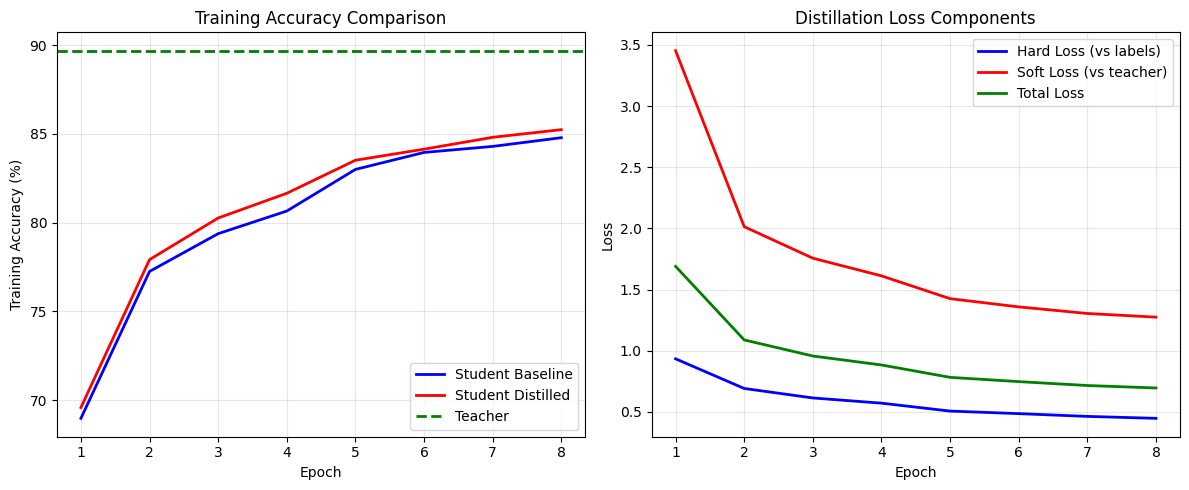

In [9]:
# Create comprehensive visualizations
fig = plt.figure(figsize=(20, 12))

# Training Accuracy and Distillation Loss Components
fig = plt.figure(figsize=(12, 5))

# Training curves comparison
ax1 = plt.subplot(1, 2, 1)
epochs_range = range(1, len(baseline_accuracies) + 1)
plt.plot(epochs_range, baseline_accuracies, 'b-', label='Student Baseline', linewidth=2)
plt.plot(epochs_range, distill_accuracies, 'r-', label='Student Distilled', linewidth=2)
plt.axhline(y=teacher_accuracy, color='g', linestyle='--', label='Teacher', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy (%)')
plt.title('Training Accuracy Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss breakdown for distillation
ax2 = plt.subplot(1, 2, 2)
plt.plot(epochs_range, hard_losses, 'b-', label='Hard Loss (vs labels)', linewidth=2)
plt.plot(epochs_range, soft_losses, 'r-', label='Soft Loss (vs teacher)', linewidth=2)
plt.plot(epochs_range, distill_losses, 'g-', label='Total Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Distillation Loss Components')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


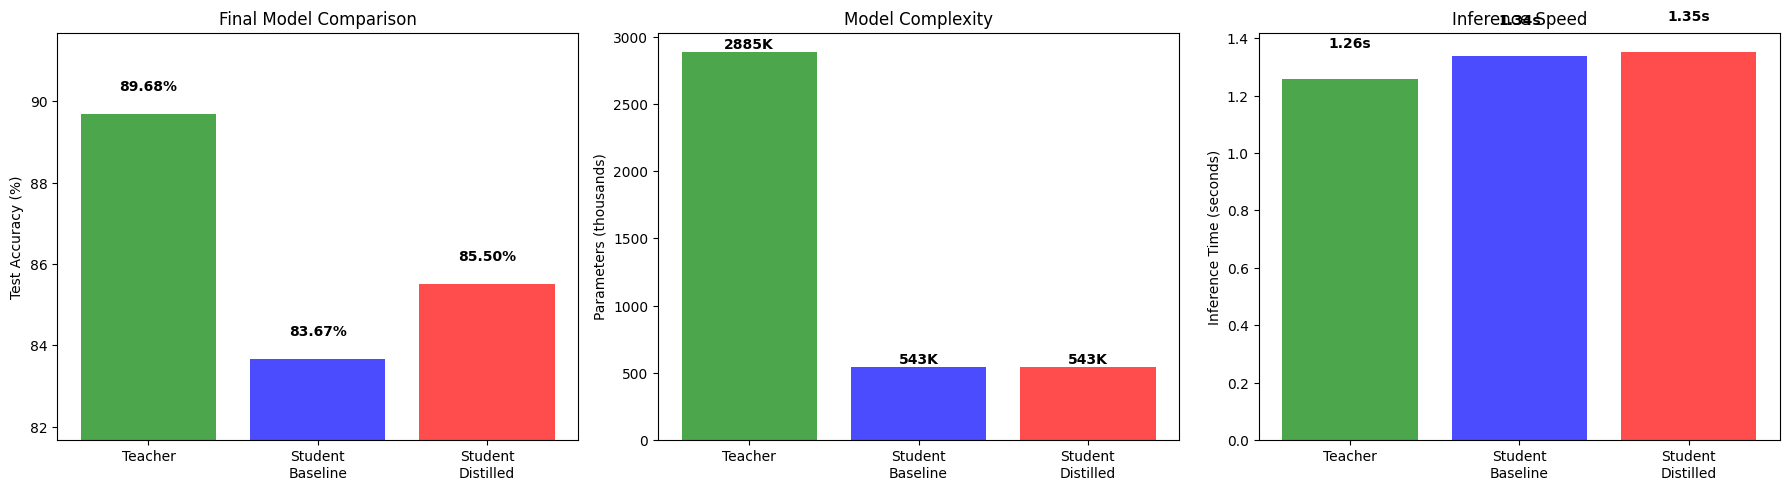

In [10]:
# Final Model Comparison, Model Complexity, and Inference Speed
fig = plt.figure(figsize=(18, 5))

# Final accuracy comparison
ax1 = plt.subplot(1, 3, 1)
model_names = ['Teacher', 'Student\nBaseline', 'Student\nDistilled']
accuracies = [teacher_accuracy, baseline_accuracy, distilled_accuracy]
colors = ['green', 'blue', 'red']
bars = plt.bar(model_names, accuracies, color=colors, alpha=0.7)
plt.ylabel('Test Accuracy (%)')
plt.title('Final Model Comparison')
plt.ylim([min(accuracies) - 2, max(accuracies) + 2])
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')

# Model complexity comparison
ax2 = plt.subplot(1, 3, 2)
params = [teacher_params/1000, student_params/1000, student_params/1000]  # In thousands
bars = plt.bar(model_names, params, color=colors, alpha=0.7)
plt.ylabel('Parameters (thousands)')
plt.title('Model Complexity')
for bar, param in zip(bars, params):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'{param:.0f}K', ha='center', va='bottom', fontweight='bold')

# Inference time comparison
ax3 = plt.subplot(1, 3, 3)
times = [teacher_time, baseline_time, distilled_time]
bars = plt.bar(model_names, times, color=colors, alpha=0.7)
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Speed')
for bar, time_val in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{time_val:.2f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Step 9: Analyze Prediction Distributions

Analyzing prediction distributions...

Prediction Similarity (lower KL divergence = more similar):
Teacher vs Student Baseline:   0.3556
Teacher vs Student Distilled:  0.3345
Improvement in similarity:     6.0%


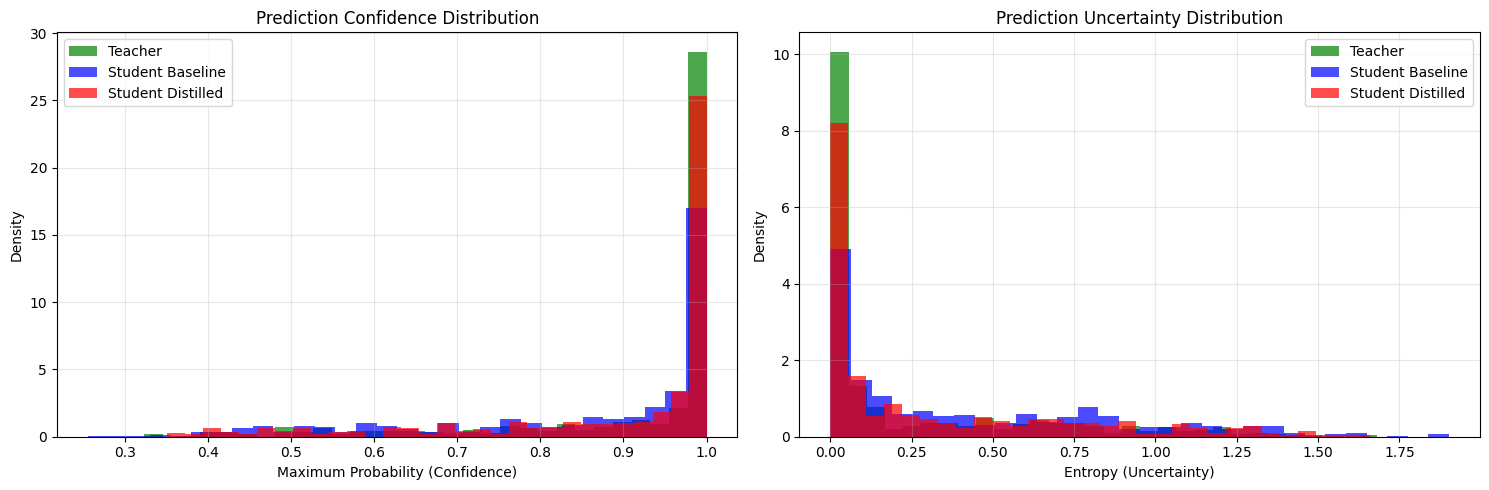

In [11]:
def analyze_prediction_distributions(teacher_model, student_baseline, student_distilled, testloader, num_samples=1000):
    """
    Analyze how similar the prediction distributions are between models
    """
    teacher_model.eval()
    student_baseline.eval()
    student_distilled.eval()
    
    teacher_probs = []
    baseline_probs = []
    distilled_probs = []
    
    samples_collected = 0
    
    with torch.no_grad():
        for inputs, labels in testloader:
            if samples_collected >= num_samples:
                break
                
            inputs = inputs.to(device)
            
            # Get predictions from all models
            teacher_outputs = F.softmax(teacher_model(inputs), dim=1)
            baseline_outputs = F.softmax(student_baseline(inputs), dim=1)
            distilled_outputs = F.softmax(student_distilled(inputs), dim=1)
            
            batch_size = inputs.size(0)
            remaining_samples = min(batch_size, num_samples - samples_collected)
            
            teacher_probs.extend(teacher_outputs[:remaining_samples].cpu().numpy())
            baseline_probs.extend(baseline_outputs[:remaining_samples].cpu().numpy())
            distilled_probs.extend(distilled_outputs[:remaining_samples].cpu().numpy())
            
            samples_collected += remaining_samples
    
    teacher_probs = np.array(teacher_probs)
    baseline_probs = np.array(baseline_probs)
    distilled_probs = np.array(distilled_probs)
    
    return teacher_probs, baseline_probs, distilled_probs

# Analyze prediction distributions
print("Analyzing prediction distributions...")
teacher_probs, baseline_probs, distilled_probs = analyze_prediction_distributions(
    teacher_model, student_baseline, student_distilled, testloader, num_samples=500
)

# Calculate KL divergences to measure similarity
def calculate_kl_divergence(p, q):
    """Calculate KL divergence between two probability distributions"""
    # Add small epsilon to avoid log(0)
    epsilon = 1e-8
    p = p + epsilon
    q = q + epsilon
    return np.mean(np.sum(p * np.log(p / q), axis=1))

# Calculate similarities
kl_teacher_baseline = calculate_kl_divergence(teacher_probs, baseline_probs)
kl_teacher_distilled = calculate_kl_divergence(teacher_probs, distilled_probs)

print(f"\nPrediction Similarity (lower KL divergence = more similar):")
print(f"Teacher vs Student Baseline:   {kl_teacher_baseline:.4f}")
print(f"Teacher vs Student Distilled:  {kl_teacher_distilled:.4f}")
print(f"Improvement in similarity:     {((kl_teacher_baseline - kl_teacher_distilled) / kl_teacher_baseline * 100):.1f}%")

# Visualize prediction confidence distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Max probability distribution (confidence)
teacher_confidence = np.max(teacher_probs, axis=1)
baseline_confidence = np.max(baseline_probs, axis=1)
distilled_confidence = np.max(distilled_probs, axis=1)

ax1.hist(teacher_confidence, bins=30, alpha=0.7, label='Teacher', color='green', density=True)
ax1.hist(baseline_confidence, bins=30, alpha=0.7, label='Student Baseline', color='blue', density=True)
ax1.hist(distilled_confidence, bins=30, alpha=0.7, label='Student Distilled', color='red', density=True)
ax1.set_xlabel('Maximum Probability (Confidence)')
ax1.set_ylabel('Density')
ax1.set_title('Prediction Confidence Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Entropy distribution (uncertainty)
teacher_entropy = -np.sum(teacher_probs * np.log(teacher_probs + 1e-8), axis=1)
baseline_entropy = -np.sum(baseline_probs * np.log(baseline_probs + 1e-8), axis=1)
distilled_entropy = -np.sum(distilled_probs * np.log(distilled_probs + 1e-8), axis=1)

ax2.hist(teacher_entropy, bins=30, alpha=0.7, label='Teacher', color='green', density=True)
ax2.hist(baseline_entropy, bins=30, alpha=0.7, label='Student Baseline', color='blue', density=True)
ax2.hist(distilled_entropy, bins=30, alpha=0.7, label='Student Distilled', color='red', density=True)
ax2.set_xlabel('Entropy (Uncertainty)')
ax2.set_ylabel('Density')
ax2.set_title('Prediction Uncertainty Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 10: Experiment with Different Distillation Parameters

Experimenting with different distillation parameters...
Testing temperature 1.0...
Temperature 1.0: 79.81% accuracy
Testing temperature 3.0...
Temperature 3.0: 80.25% accuracy
Testing temperature 5.0...
Temperature 5.0: 80.05% accuracy
Testing temperature 8.0...
Temperature 8.0: 79.88% accuracy
Testing alpha 0.3...
Alpha 0.3: 80.31% accuracy
Testing alpha 0.5...
Alpha 0.5: 80.05% accuracy
Testing alpha 0.7...
Alpha 0.7: 80.31% accuracy
Testing alpha 0.9...
Alpha 0.9: 80.53% accuracy


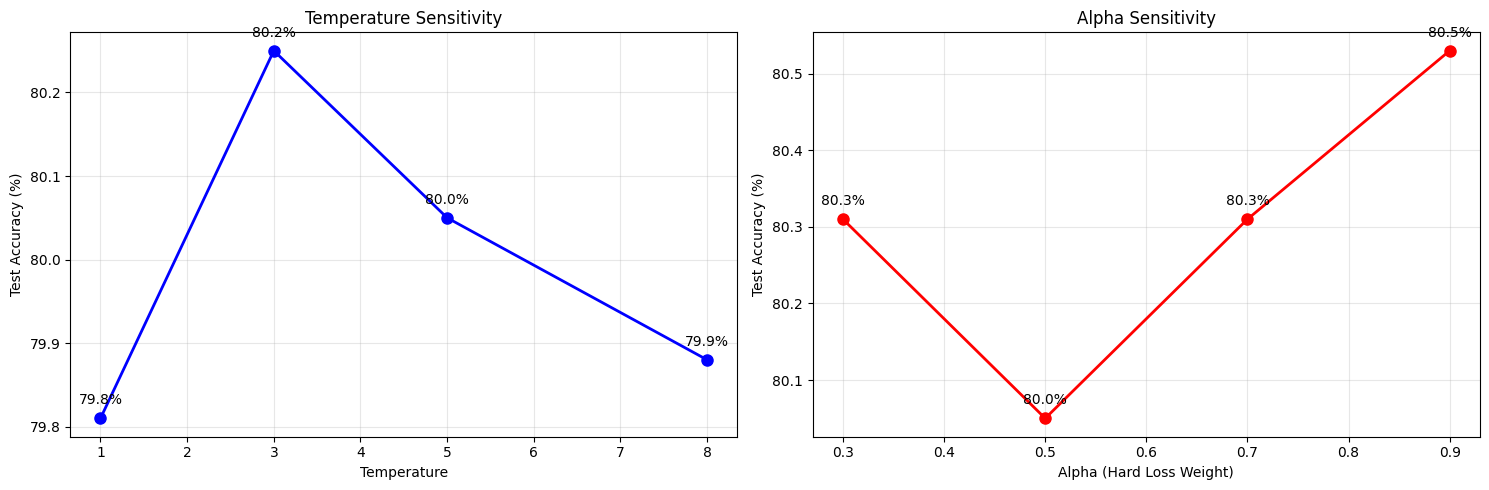


Best temperature: 3.0 (accuracy: 80.25%)
Best alpha: 0.9 (accuracy: 80.53%)


In [12]:
def quick_distillation_experiment(teacher_model, temperature=4.0, alpha=0.5, epochs=3):
    """
    Quick experiment to test different distillation parameters
    """
    # Create a new student model
    student = create_student_mobilenetv2(num_classes=10).to(device)
    
    # Train with distillation
    distillation_criterion = DistillationLoss(alpha=alpha, temperature=temperature)
    optimizer = optim.Adam(student.parameters(), lr=0.001, weight_decay=1e-4)
    
    teacher_model.eval()
    
    for epoch in range(epochs):
        student.train()
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            with torch.no_grad():
                teacher_outputs = teacher_model(inputs)
            
            optimizer.zero_grad()
            student_outputs = student(inputs)
            
            total_loss, _, _ = distillation_criterion(student_outputs, teacher_outputs, labels)
            total_loss.backward()
            optimizer.step()
    
    # Quick evaluation
    student.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = student(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    accuracy = 100. * correct / total
    return accuracy

# Experiment with different parameters
print("Experimenting with different distillation parameters...")

temperatures = [1.0, 3.0, 5.0, 8.0]
alphas = [0.3, 0.5, 0.7, 0.9]

# Temperature experiment
temp_results = []
for temp in temperatures:
    print(f"Testing temperature {temp}...")
    acc = quick_distillation_experiment(teacher_model, temperature=temp, alpha=0.7, epochs=2)
    temp_results.append(acc)
    print(f"Temperature {temp}: {acc:.2f}% accuracy")

# Alpha experiment
alpha_results = []
for alpha in alphas:
    print(f"Testing alpha {alpha}...")
    acc = quick_distillation_experiment(teacher_model, temperature=4.0, alpha=alpha, epochs=2)
    alpha_results.append(acc)
    print(f"Alpha {alpha}: {acc:.2f}% accuracy")

# Visualize parameter sensitivity
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Temperature sensitivity
ax1.plot(temperatures, temp_results, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Test Accuracy (%)')
ax1.set_title('Temperature Sensitivity')
ax1.grid(True, alpha=0.3)

for i, (temp, acc) in enumerate(zip(temperatures, temp_results)):
    ax1.annotate(f'{acc:.1f}%', (temp, acc), textcoords="offset points", xytext=(0,10), ha='center')

# Alpha sensitivity
ax2.plot(alphas, alpha_results, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Alpha (Hard Loss Weight)')
ax2.set_ylabel('Test Accuracy (%)')
ax2.set_title('Alpha Sensitivity')
ax2.grid(True, alpha=0.3)

for i, (alpha, acc) in enumerate(zip(alphas, alpha_results)):
    ax2.annotate(f'{acc:.1f}%', (alpha, acc), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

print(f"\nBest temperature: {temperatures[np.argmax(temp_results)]} (accuracy: {max(temp_results):.2f}%)")
print(f"Best alpha: {alphas[np.argmax(alpha_results)]} (accuracy: {max(alpha_results):.2f}%)")